<h1>Spacial density of Na and K in various traps</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union

from quantum_statistics import BEC, ParticleProps

In [2]:
def harmonic_trap(
        x: Union[float, np.ndarray],
        y: Union[float, np.ndarray],
        z: Union[float, np.ndarray],
        trap_depth: float = 200,
        waist: float = 50,
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 80μm.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z
    """
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)
    return -trap_depth * gaussian_profile

## Plot the harmonic trap potential along the x-axis, i.e. V(x,0,0)
#x = np.linspace(-75, 75, 101) 
#y = np.linspace(-75, 75, 101) 
#z = np.linspace(-75, 75, 101) 
#
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#fig.suptitle(r'Isotropic harmonic potential, $d=200nK$, $\omega=50 \mu m$', fontsize=24)
#
#axs[0].plot(x, harmonic_trap(x,0,0))
#axs[0].set_xlabel(r'$x[\mu m]$', fontsize=18)
#axs[0].set_ylabel(r'$V(x,0,0) \; [nK]$', fontsize=18)
#axs[0].set_title('V(x,0,0)', fontsize=18)
#axs[0].grid(True)
#
#axs[1].plot(x, harmonic_trap(0,y,0))
#axs[1].set_xlabel(r'$y[\mu m]$', fontsize=18)
#axs[1].set_ylabel(r'$V(0,y,0) \; [nK]$', fontsize=18)
#axs[1].set_title('V(0,y,0)', fontsize=18)
#axs[1].grid(True)
#
#axs[2].plot(x, harmonic_trap(0,0,z))
#axs[2].set_xlabel(r'$z[\mu m]$', fontsize=18)
#axs[2].set_ylabel(r'$V(0,0,z,) \; [nK]$', fontsize=18)
#axs[2].set_title('V(0,0,z)', fontsize=18)
#axs[2].grid(True)
#
#fig.tight_layout()

In [3]:
na = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=20*u.nK,
    domain=(-100, 100) * u.um,
    V_trap=harmonic_trap,
    trap_depth=200*u.nK,
    a_s=2.75*u.nm,
)

k = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=200000,
    T=20*u.nK,
    domain=(-100, 100) * u.um,
    V_trap=harmonic_trap,
    trap_depth=17*200*u.nK,
)

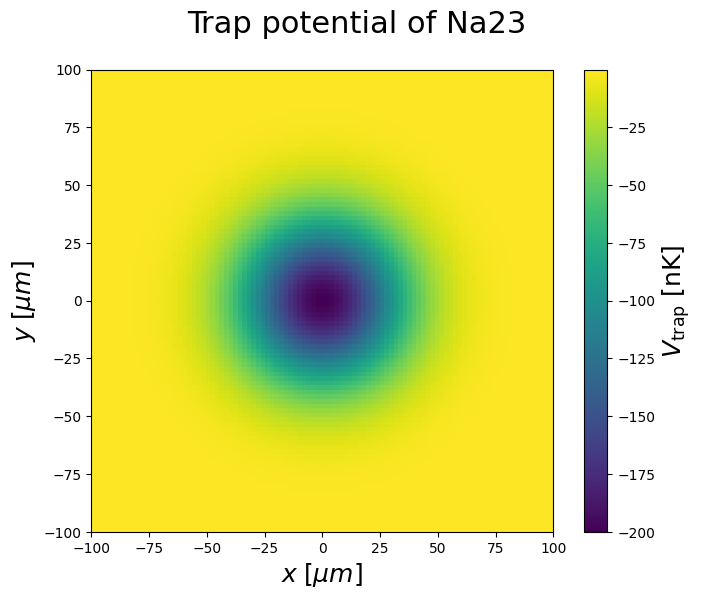

In [6]:
na.plot_V_trap(x=np.linspace(-100, 100, 101), y=np.linspace(-100, 100, 101), z=0)